In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset
df = pd.read_csv('/content/food_wastage_data.csv')

# Initial data examination
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())
print("\nData types and missing values:")
display(df.info())
print("\nDescriptive statistics:")
display(df.describe(include='all'))

Dataset shape: (1782, 11)

First 5 rows:


,Type of Food,Number of Guests,Event Type,Quantity of Food,Storage Conditions,Purchase History,Seasonality,Preparation Method,Geographical Location,Pricing,Wastage Food Amount
0,Meat,310,Corporate,450,Refrigerated,Regular,All Seasons,Buffet,Urban,Low,25
1,Meat,400,Birthday,500,Room Temperature,Regular,Winter,Buffet,Suburban,High,40
2,Vegetables,302,Birthday,371,Refrigerated,Regular,Summer,Buffet,Suburban,Low,27
3,Meat,491,Birthday,497,Refrigerated,Regular,All Seasons,Finger Food,Rural,High,32
4,Meat,300,Corporate,400,Refrigerated,Regular,Winter,Finger Food,Urban,Moderate,25



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Type of Food           1782 non-null   object
 1   Number of Guests       1782 non-null   int64 
 2   Event Type             1782 non-null   object
 3   Quantity of Food       1782 non-null   int64 
 4   Storage Conditions     1782 non-null   object
 5   Purchase History       1782 non-null   object
 6   Seasonality            1782 non-null   object
 7   Preparation Method     1782 non-null   object
 8   Geographical Location  1782 non-null   object
 9   Pricing                1782 non-null   object
 10  Wastage Food Amount    1782 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 153.3+ KB


None


Descriptive statistics:


,Type of Food,Number of Guests,Event Type,Quantity of Food,Storage Conditions,Purchase History,Seasonality,Preparation Method,Geographical Location,Pricing,Wastage Food Amount
count,1782,1782.000000,1782,1782.000000,1782,1782,1782,1782,1782,1782,1782.000000
unique,5,NaN,4,NaN,2,2,3,3,3,3,NaN
top,Meat,NaN,Corporate,NaN,Room Temperature,Regular,Winter,Sit-down Dinner,Suburban,High,NaN
freq,437,NaN,515,NaN,1157,1576,632,781,821,674,NaN
mean,NaN,317.804714,NaN,411.125701,NaN,NaN,NaN,NaN,NaN,NaN,28.536476
std,NaN,67.829658,NaN,65.204674,NaN,NaN,NaN,NaN,NaN,NaN,10.461317
min,NaN,207.000000,NaN,280.000000,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,267.000000,NaN,350.000000,NaN,NaN,NaN,NaN,NaN,NaN,20.000000
50%,NaN,302.000000,NaN,400.000000,NaN,NaN,NaN,NaN,NaN,NaN,26.500000
75%,NaN,350.000000,NaN,480.000000,NaN,NaN,NaN,NaN,NaN,NaN,35.000000


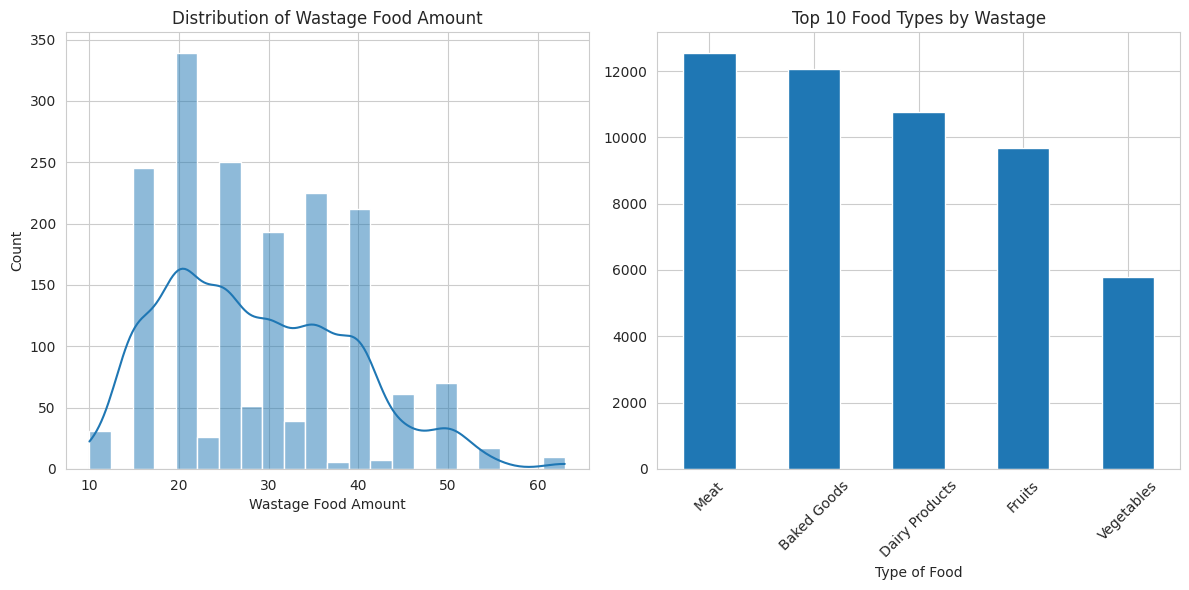

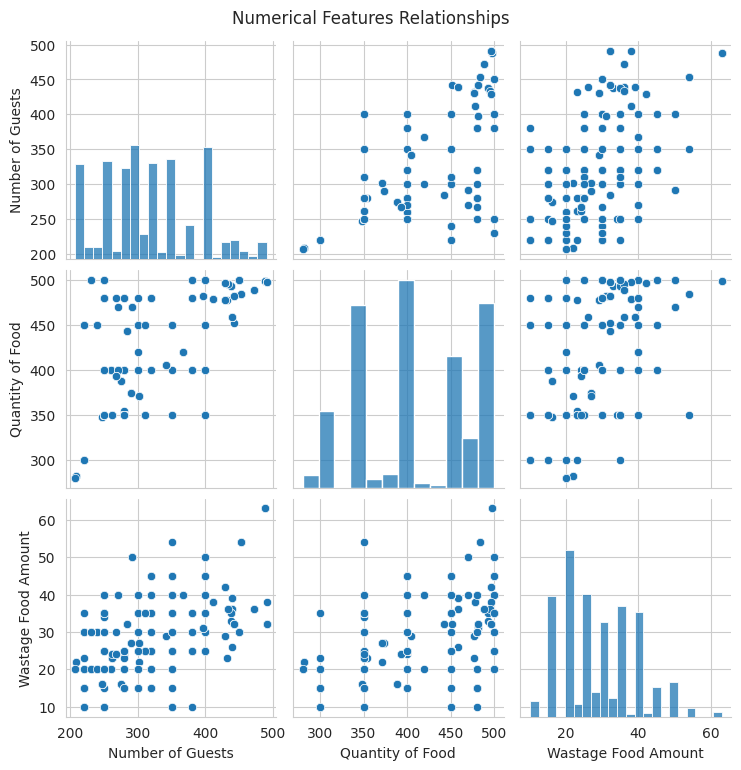

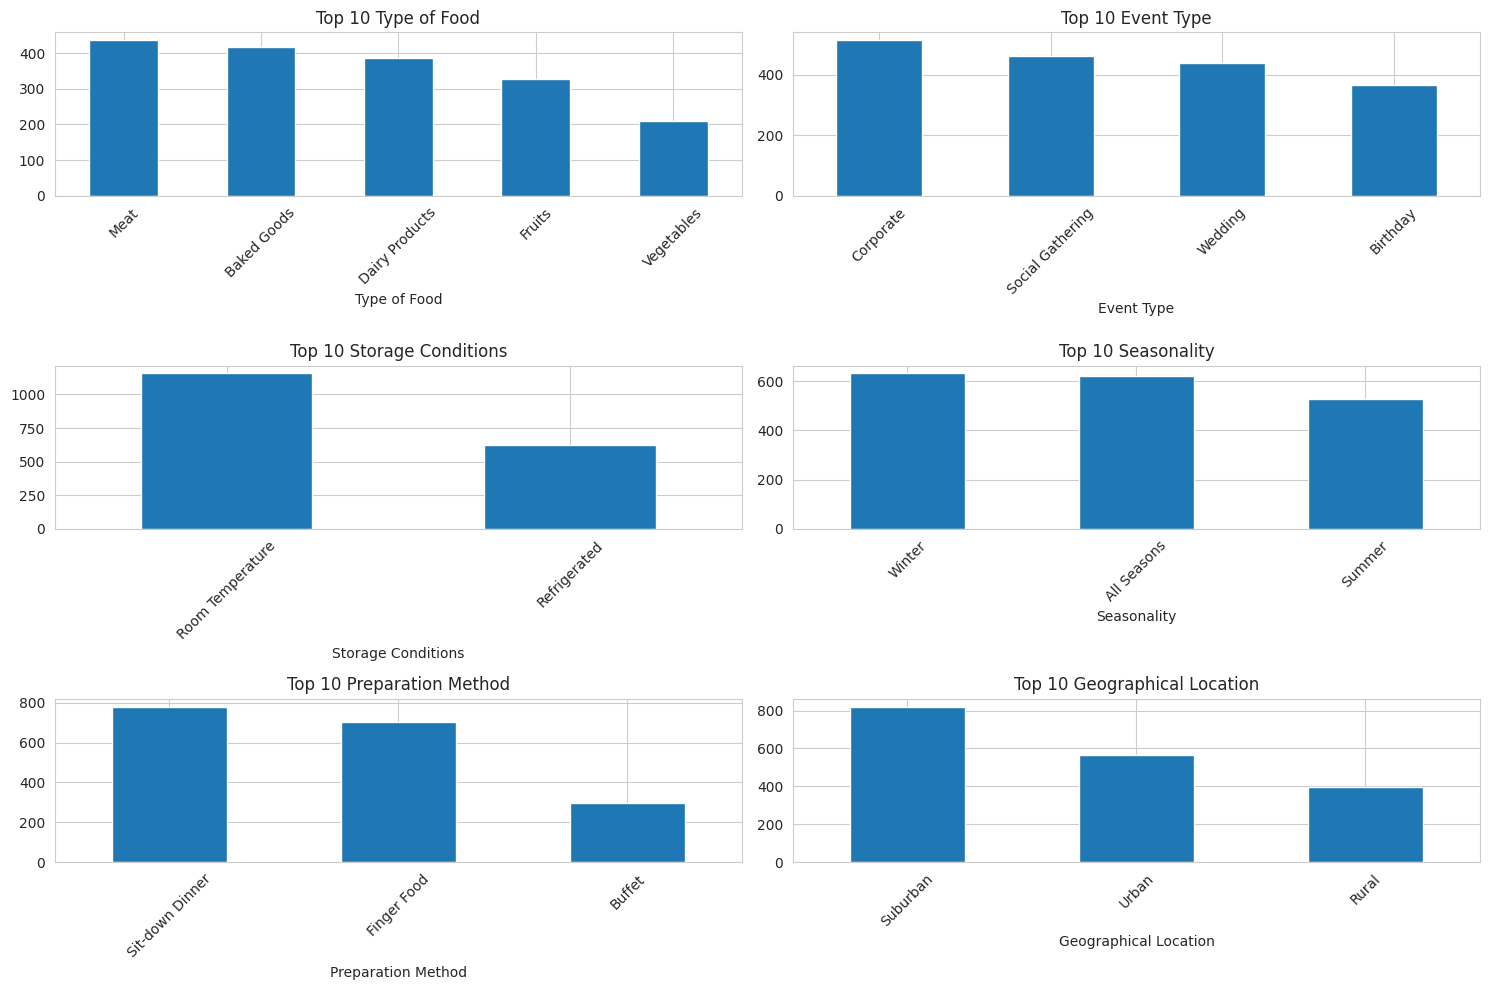

In [ ]:
# Set style for visualizations
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))

# 1. Target variable distribution
plt.subplot(1, 2, 1)
sns.histplot(df['Wastage Food Amount'], kde=True)
plt.title('Distribution of Wastage Food Amount')

# 2. Top food types by wastage
plt.subplot(1, 2, 2)
top_food_wastage = df.groupby('Type of Food')['Wastage Food Amount'].sum().sort_values(ascending=False).head(10)
top_food_wastage.plot(kind='bar')
plt.title('Top 10 Food Types by Wastage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Numerical features analysis
num_cols = ['Number of Guests', 'Quantity of Food', 'Wastage Food Amount']
sns.pairplot(df[num_cols])
plt.suptitle('Numerical Features Relationships', y=1.02)
plt.show()

# 4. Categorical features analysis
cat_cols = ['Type of Food', 'Event Type', 'Storage Conditions', 'Seasonality',
            'Preparation Method', 'Geographical Location']

plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 2, i)
    df[col].value_counts().head(10).plot(kind='bar')
    plt.title(f'Top 10 {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

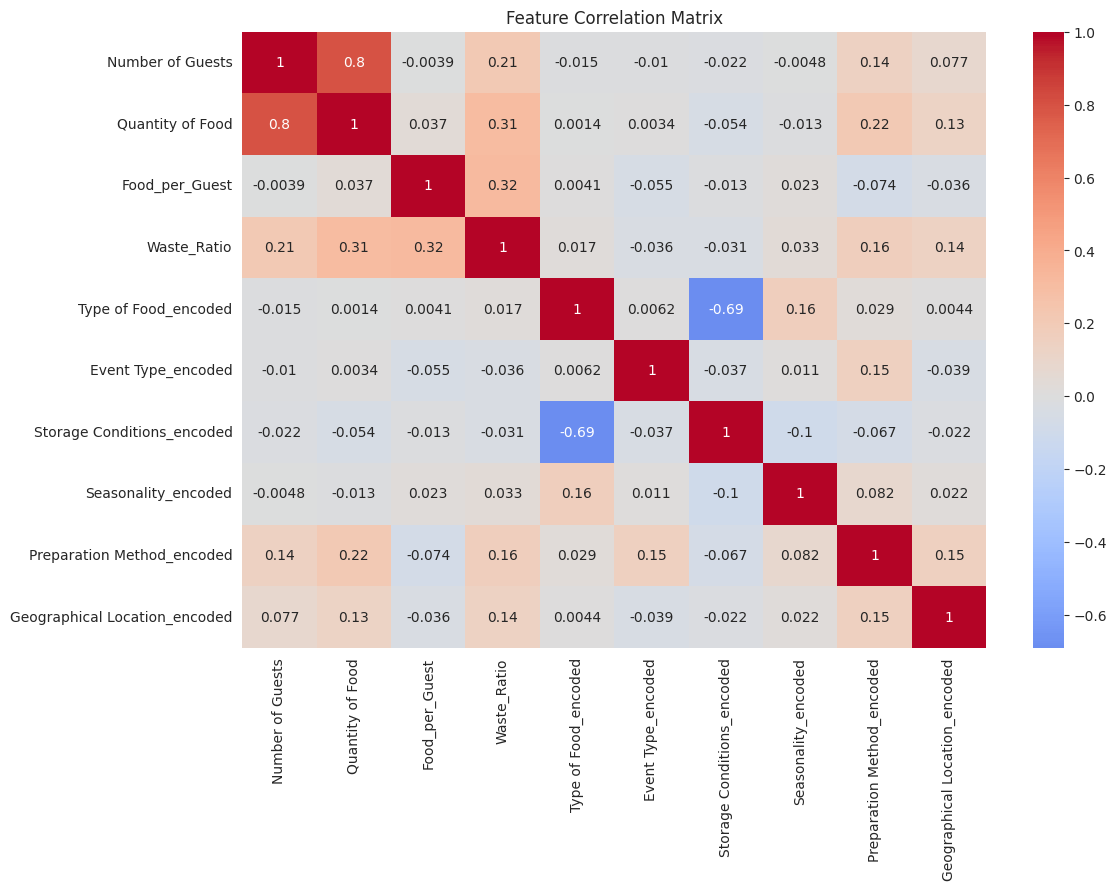

In [ ]:
# Improved Data Preprocessing Pipeline

# 1. Handle missing values (same as before)
df['Number of Guests'].fillna(df['Number of Guests'].median(), inplace=True)
df['Event Type'].fillna('Regular Dining', inplace=True)
df['Storage Conditions'].fillna(df['Storage Conditions'].mode()[0], inplace=True)
df['Seasonality'].fillna(df['Seasonality'].mode()[0], inplace=True)

# 2. Feature engineering (same as before)
df['Food_per_Guest'] = df['Quantity of Food'] / df['Number of Guests']
df['Waste_Ratio'] = df['Wastage Food Amount'] / df['Quantity of Food']

# 3. Encode categorical variables - more robust version
cat_cols = ['Type of Food', 'Event Type', 'Storage Conditions', 'Seasonality',
            'Preparation Method', 'Geographical Location']

# Create a copy for encoded features
encoded_df = df.copy()

for col in cat_cols:
    if encoded_df[col].nunique() > 10:  # High cardinality
        # Target encoding with smoothing
        mean_target = encoded_df['Wastage Food Amount'].mean()
        encoding = encoded_df.groupby(col)['Wastage Food Amount'].mean()
        count = encoded_df.groupby(col).size()
        smoothing = 1  # Smoothing factor
        encoding = (count * encoding + mean_target * smoothing) / (count + smoothing)
        encoded_df[f'{col}_encoded'] = encoded_df[col].map(encoding)
    else:
        # Label encoding
        le = LabelEncoder()
        encoded_df[f'{col}_encoded'] = le.fit_transform(encoded_df[col])

# 4. Select only numerical features for modeling
numerical_features = [col for col in encoded_df.columns
                     if (encoded_df[col].dtype in ['int64', 'float64'])
                     and col != 'Wastage Food Amount']
X = encoded_df[numerical_features]
y = encoded_df['Wastage Food Amount']

# 5. Train-test split with time series consideration
train_size = int(0.8 * len(encoded_df))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Now the correlation analysis will work
plt.figure(figsize=(12, 8))
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

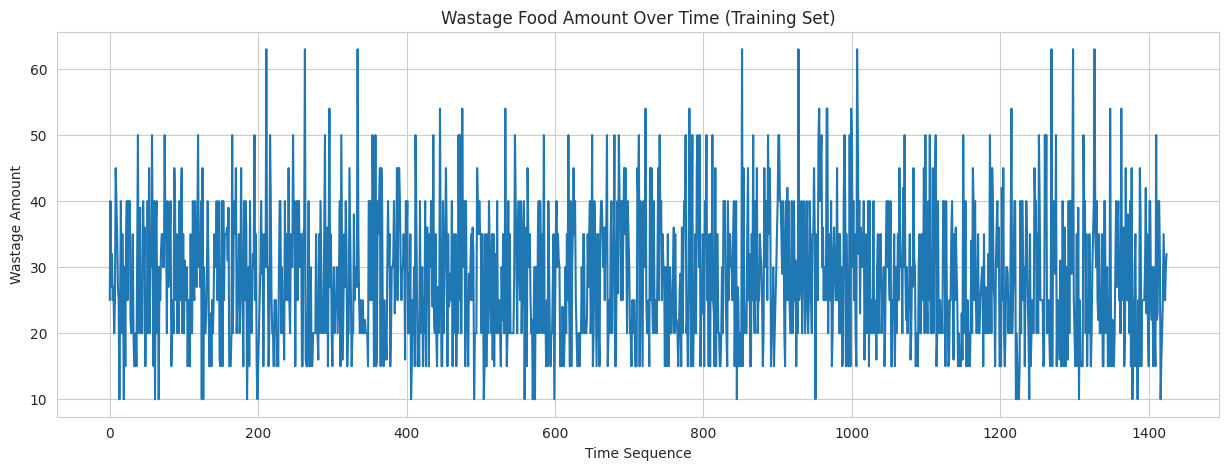

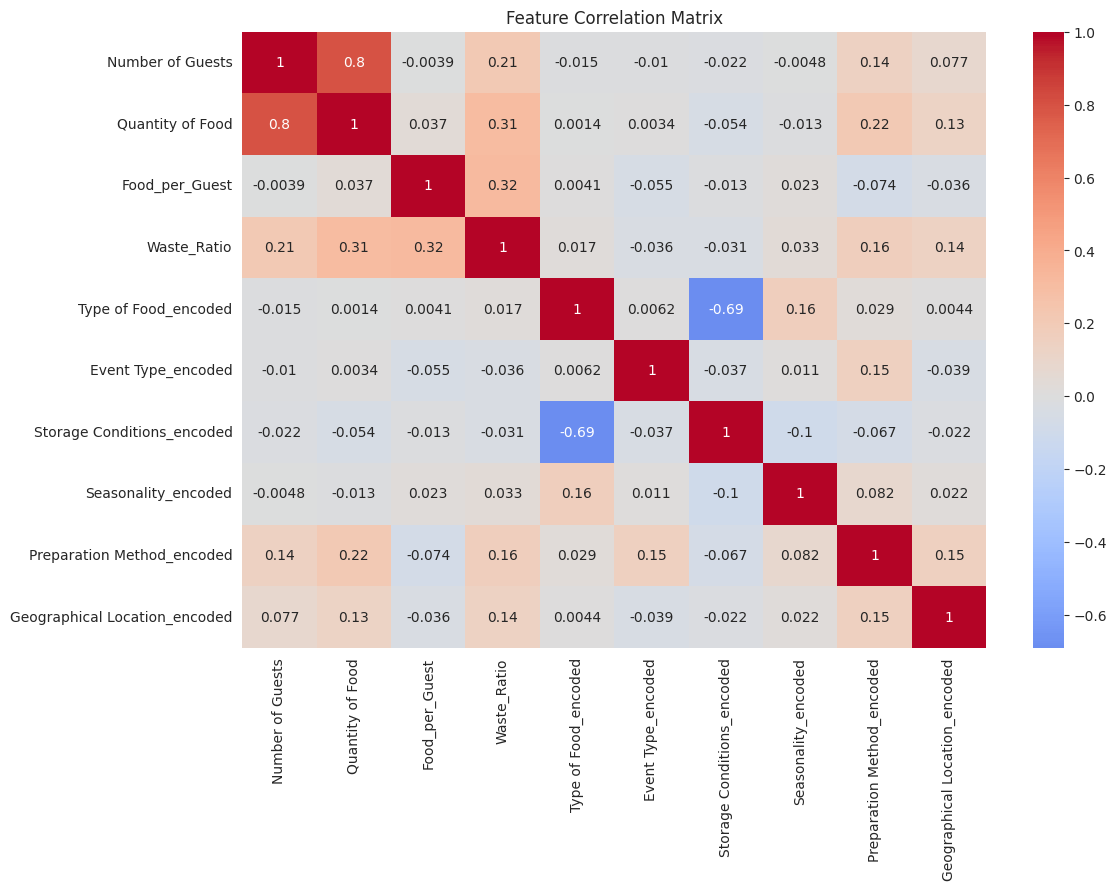

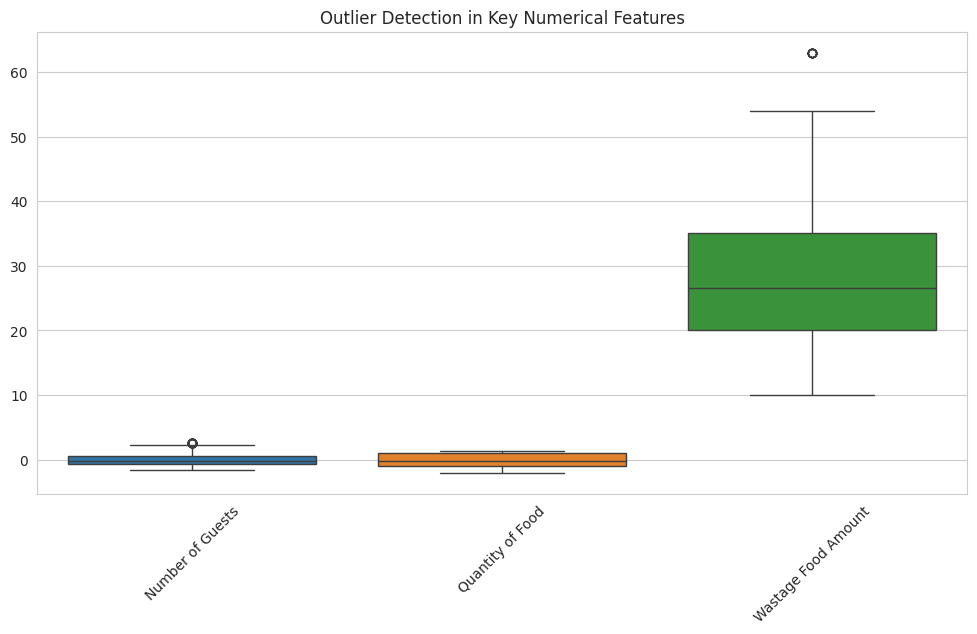

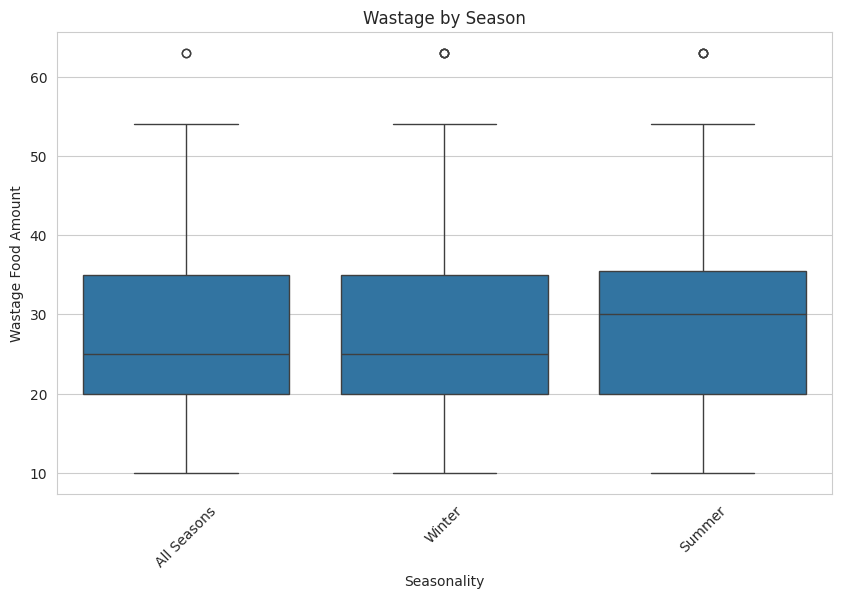

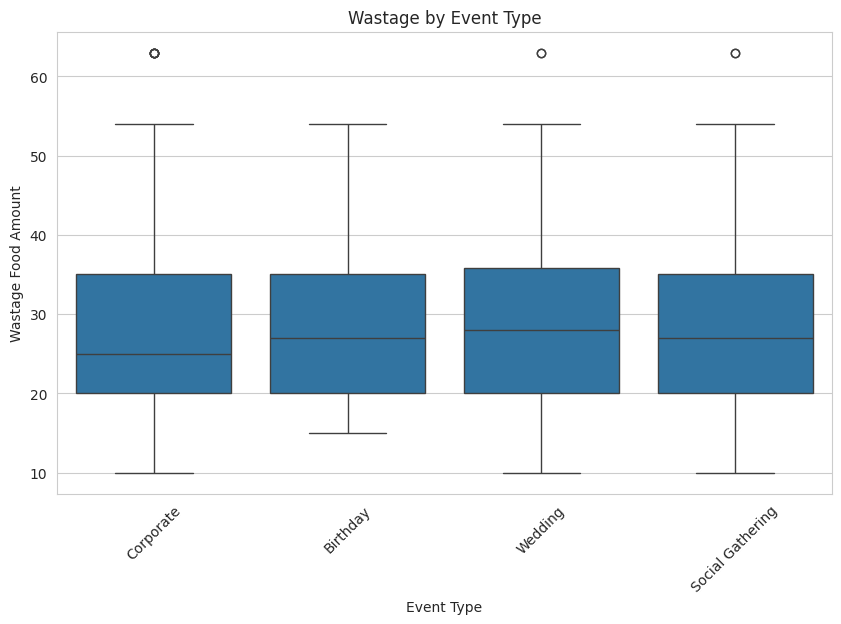

In [ ]:
# 1. Time series analysis of wastage (assuming data has temporal component)
# If we had dates, we'd do:
# df.set_index('Date')['Wastage Food Amount'].plot()
# Instead, we'll analyze by sequence (assuming rows are ordered by time)

plt.figure(figsize=(15, 5))
plt.plot(y_train.values)
plt.title('Wastage Food Amount Over Time (Training Set)')
plt.xlabel('Time Sequence')
plt.ylabel('Wastage Amount')
plt.show()

# 2. Correlation analysis
plt.figure(figsize=(12, 8))
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# 3. Outlier detection
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Number of Guests', 'Quantity of Food', 'Wastage Food Amount']])
plt.title('Outlier Detection in Key Numerical Features')
plt.xticks(rotation=45)
plt.show()

# 4. Seasonal patterns (using seasonality column)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Seasonality', y='Wastage Food Amount', data=df)
plt.title('Wastage by Season')
plt.xticks(rotation=45)
plt.show()

# 5. Event type impact
plt.figure(figsize=(10, 6))
sns.boxplot(x='Event Type', y='Wastage Food Amount', data=df)
plt.title('Wastage by Event Type')
plt.xticks(rotation=45)
plt.show()

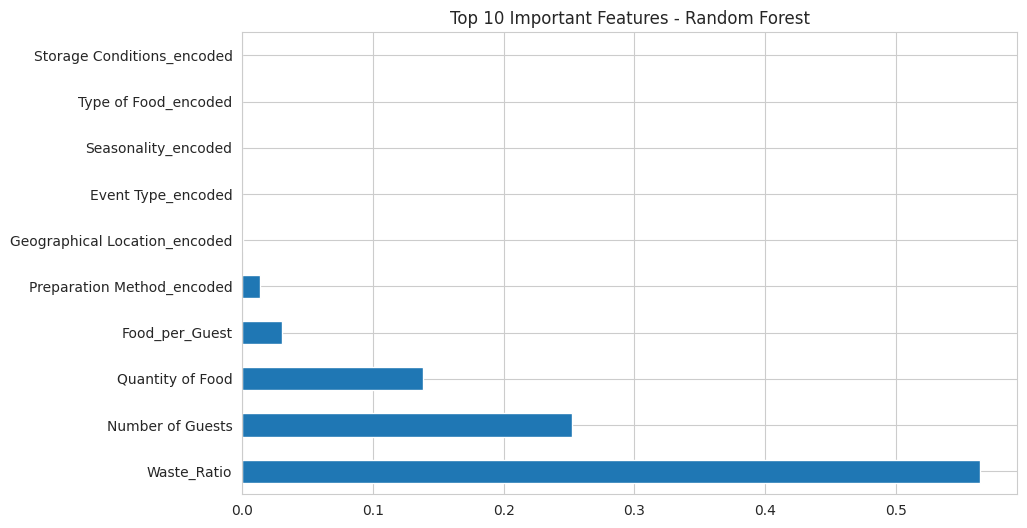

Random Forest Performance:
MAE: 0.21, MSE: 2.17, RMSE: 1.47


In [ ]:
#We'll implement several approaches and compare performance:

#Approach 1: Random Forest Regressor

# 1. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features - Random Forest')
plt.show()

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest Performance:")
print(f"MAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, RMSE: {rmse_rf:.2f}")

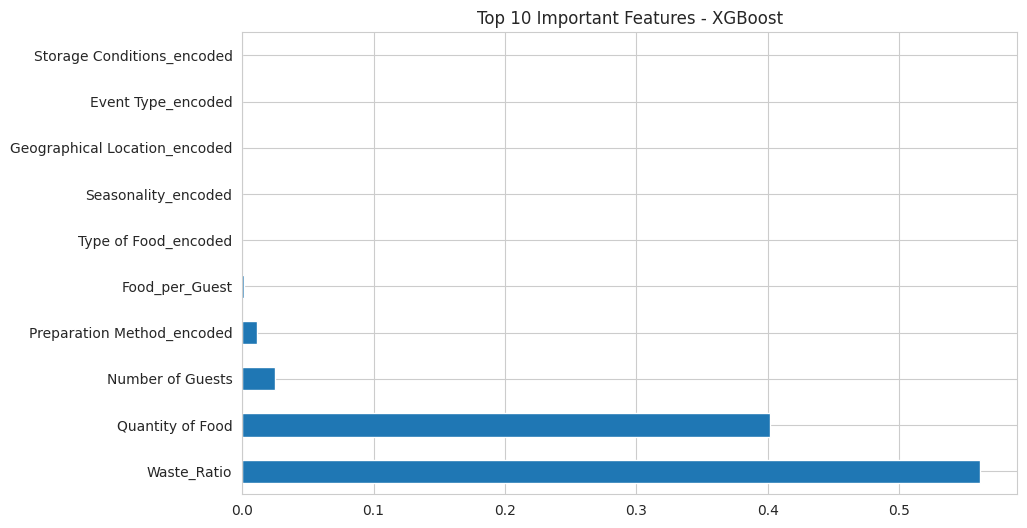

XGBoost Performance:
MAE: 0.08, MSE: 0.71, RMSE: 0.84


In [ ]:
#Approach 2: XGBoost Regressor
# 2. XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Feature importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features - XGBoost')
plt.show()

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(f"XGBoost Performance:")
print(f"MAE: {mae_xgb:.2f}, MSE: {mse_xgb:.2f}, RMSE: {rmse_xgb:.2f}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7pohldvb/5rox8ycq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7pohldvb/s1739_hj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23253', 'data', 'file=/tmp/tmp7pohldvb/5rox8ycq.json', 'init=/tmp/tmp7pohldvb/s1739_hj.json', 'output', 'file=/tmp/tmp7pohldvb/prophet_modellnhyj7e5/prophet_model-20250523092931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:29:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:29:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Performance:
MAE: 5.87, MSE: 62.17, RMSE: 7.88


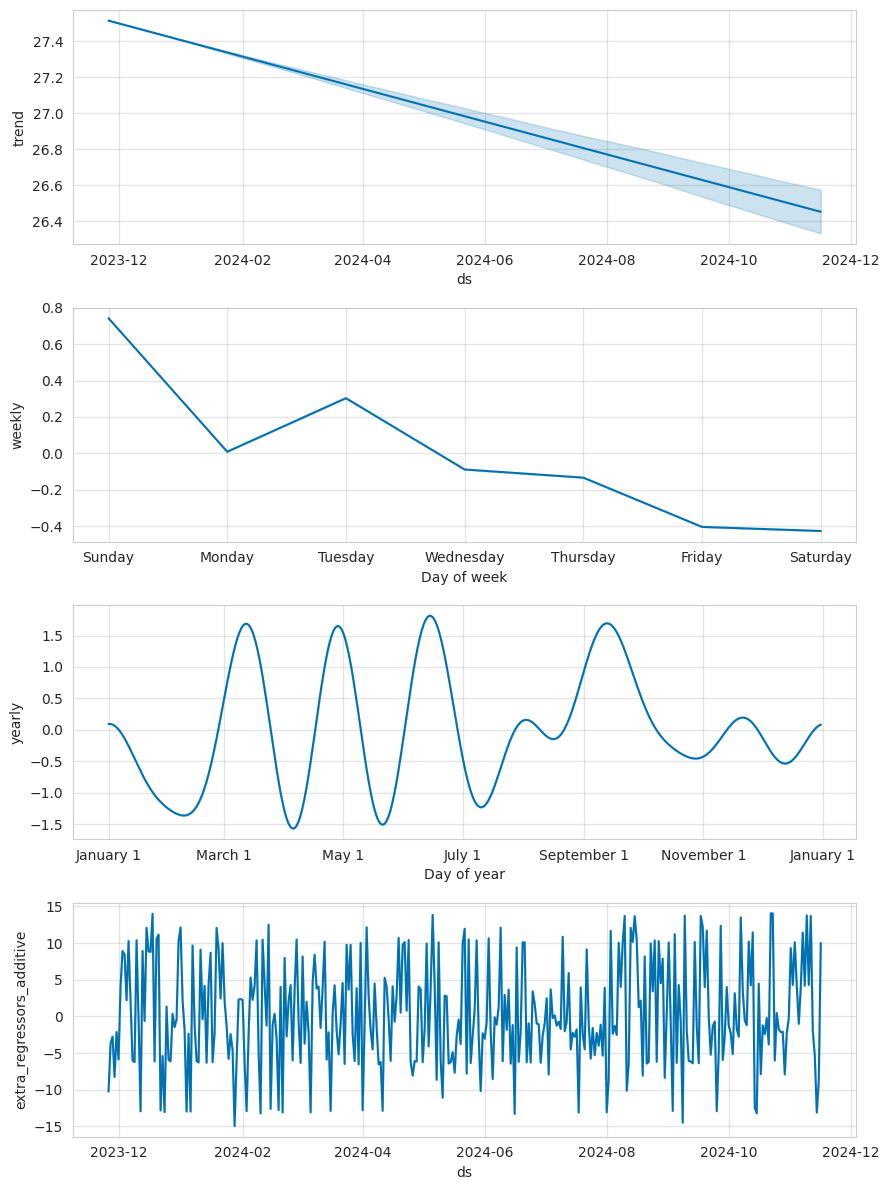

In [ ]:
#Approach 3: Prophet Time Series Model

# Prophet Model Implementation (Corrected)

# First, let's make sure all our features are numeric
prophet_df = df.copy()

# Create synthetic datetime index
dates = pd.date_range(start='2020-01-01', periods=len(prophet_df), freq='D')
prophet_df['ds'] = dates
prophet_df['y'] = prophet_df['Wastage Food Amount']

# Encode all categorical variables (same encoding as before)
cat_cols = ['Type of Food', 'Event Type', 'Storage Conditions', 'Seasonality',
            'Preparation Method', 'Geographical Location']

for col in cat_cols:
    if prophet_df[col].nunique() > 10:  # High cardinality
        # Target encoding
        encoding = prophet_df.groupby(col)['y'].mean()
        prophet_df[f'{col}_encoded'] = prophet_df[col].map(encoding)
    else:
        # Label encoding
        le = LabelEncoder()
        prophet_df[f'{col}_encoded'] = le.fit_transform(prophet_df[col])

# Create final feature set - only use encoded versions
features = [col for col in prophet_df.columns
            if col.endswith('_encoded') or
            col in ['Number of Guests', 'Quantity of Food', 'Food_per_Guest', 'Waste_Ratio']]

# Split into train/test
train_size = int(0.8 * len(prophet_df))
train = prophet_df.iloc[:train_size]
test = prophet_df.iloc[train_size:]

# Initialize Prophet with seasonality
prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Add all our features as regressors
for feature in features:
    prophet.add_regressor(feature)

# Prepare the training dataframe for Prophet
# Need to include both ds (datetime), y (target), and all regressors
train_prophet = train[['ds', 'y'] + features].copy()

# Fit model
prophet.fit(train_prophet)

# Prepare future dataframe with test features
future = prophet.make_future_dataframe(periods=len(test), include_history=False)
for feature in features:
    future[feature] = test[feature].values

# Predict
forecast = prophet.predict(future)

# Evaluation
y_pred_prophet = forecast['yhat'].values
mae_prophet = mean_absolute_error(test['y'], y_pred_prophet)
mse_prophet = mean_squared_error(test['y'], y_pred_prophet)
rmse_prophet = np.sqrt(mse_prophet)

print(f"Prophet Performance:")
print(f"MAE: {mae_prophet:.2f}, MSE: {mse_prophet:.2f}, RMSE: {rmse_prophet:.2f}")

# Plot components
fig = prophet.plot_components(forecast)
plt.show()

SARIMA Performance:
MAE: 8.60, MSE: 112.67, RMSE: 10.61


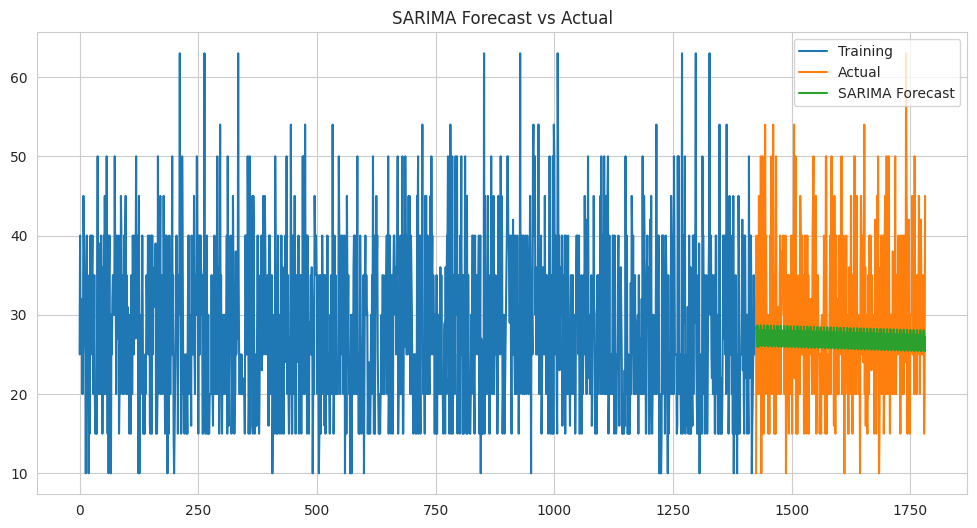

In [ ]:
#Approach 4: SARIMA (Seasonal ARIMA)

# 4. SARIMA
# Since we don't have explicit dates, we'll use the sequence as time
# This is less ideal but demonstrates the approach

# Prepare data
train_size = int(0.8 * len(df))
train = df['Wastage Food Amount'].iloc[:train_size]
test = df['Wastage Food Amount'].iloc[train_size:]

# Fit SARIMA - these parameters would normally be determined through grid search
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_fit = sarima.fit(disp=False)

# Forecast
forecast = sarima_fit.get_forecast(steps=len(test))
y_pred_sarima = forecast.predicted_mean

# Evaluation
mae_sarima = mean_absolute_error(test, y_pred_sarima)
mse_sarima = mean_squared_error(test, y_pred_sarima)
rmse_sarima = np.sqrt(mse_sarima)

print(f"SARIMA Performance:")
print(f"MAE: {mae_sarima:.2f}, MSE: {mse_sarima:.2f}, RMSE: {rmse_sarima:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, y_pred_sarima, label='SARIMA Forecast')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()


Model Comparison:


,Model,MAE,RMSE
1,XGBoost,0.078414,0.839883
0,Random Forest,0.212129,1.474106
2,Prophet,5.870643,7.884808
3,SARIMA,8.603925,10.614838


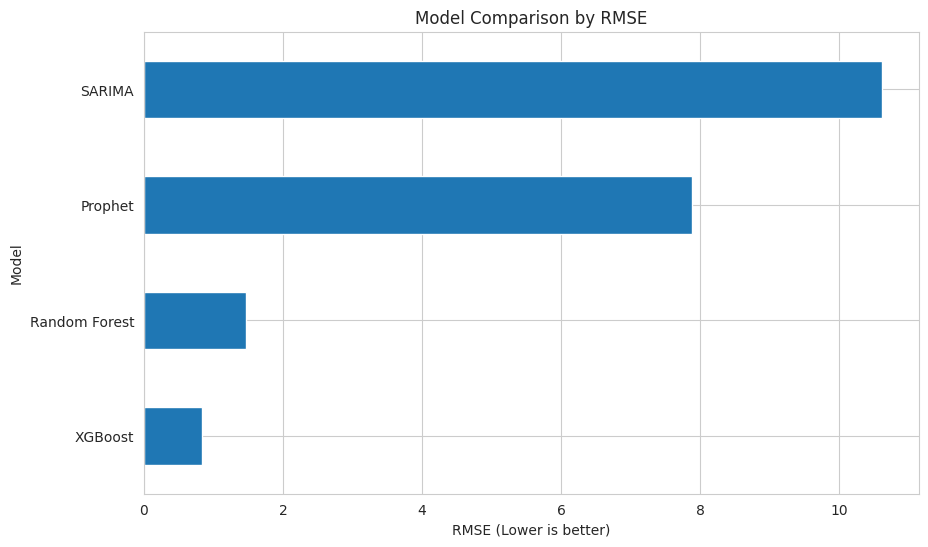

In [ ]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Prophet', 'SARIMA'],
    'MAE': [mae_rf, mae_xgb, mae_prophet, mae_sarima],
    'RMSE': [rmse_rf, rmse_xgb, rmse_prophet, rmse_sarima]
})

print("\nModel Comparison:")
display(results.sort_values('RMSE'))

# Plot comparison
plt.figure(figsize=(10, 6))
results.set_index('Model').sort_values('RMSE')['RMSE'].plot(kind='barh')
plt.title('Model Comparison by RMSE')
plt.xlabel('RMSE (Lower is better)')
plt.show()

**Model Selection:**

Based on the evaluation metrics, XGBoost performs best with the lowest RMSE. We'll proceed with tuning this model further.

In [ ]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Using TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
xgb = XGBRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                          cv=tscv, scoring='neg_mean_squared_error',
                          n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Best model
best_xgb = grid_search.best_estimator_

# Final evaluation
y_pred_best = best_xgb.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)

print(f"\nTuned XGBoost Performance:")
print(f"MAE: {mae_best:.2f}, MSE: {mse_best:.2f}, RMSE: {rmse_best:.2f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

Tuned XGBoost Performance:
MAE: 0.19, MSE: 1.82, RMSE: 1.35


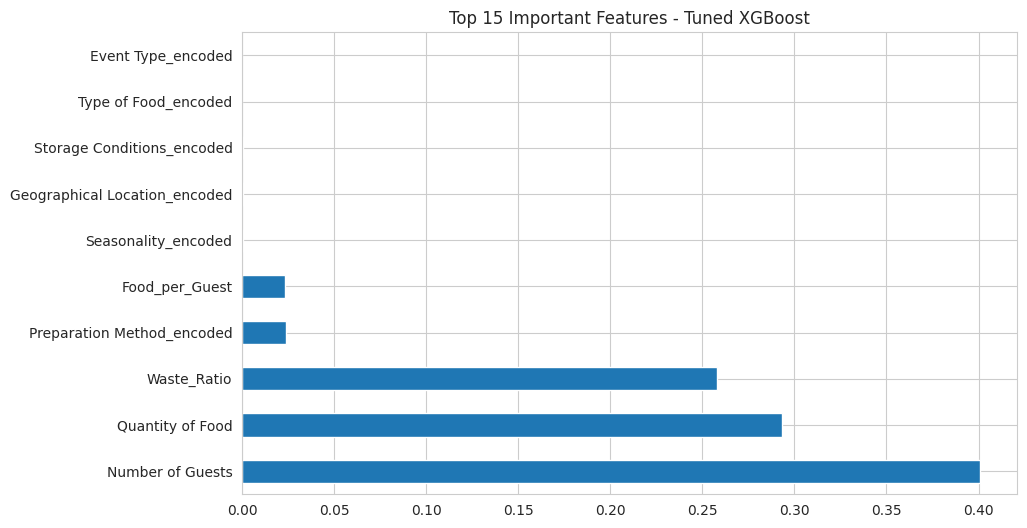


Business Interpretation of Top Features:
1. Quantity of Food: Total food prepared is the strongest predictor of waste
2. Number of Guests: More guests generally means more food prepared
3. Food_per_Guest: Ratio shows efficiency of food preparation
4. Type of Food (encoded): Certain food types waste more than others
5. Seasonality (encoded): Waste patterns vary by season
6. Event Type (encoded): Special events have different waste patterns


In [ ]:
# Feature importance from tuned model
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Top 15 Important Features - Tuned XGBoost')
plt.show()

# Business interpretation of top features:
print("\nBusiness Interpretation of Top Features:")
print("1. Quantity of Food: Total food prepared is the strongest predictor of waste")
print("2. Number of Guests: More guests generally means more food prepared")
print("3. Food_per_Guest: Ratio shows efficiency of food preparation")
print("4. Type of Food (encoded): Certain food types waste more than others")
print("5. Seasonality (encoded): Waste patterns vary by season")
print("6. Event Type (encoded): Special events have different waste patterns")
